In [1]:
import numpy as np
import xarray as xr
import math
from glob import glob
from datetime import timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
import sys
import cosima_cookbook as cc
import cmocean as cm
from scipy.interpolate import interpn
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
from dask.distributed import Client
import xgcm
from gsw import f, grav, p_from_z
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
session = cc.database.create_session()

In [3]:
client = Client()

In [4]:
zds = xr.open_mfdataset(
    #f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output12*/ocean/ocean-2d*daily*.nc",
    f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output12*/ocean/ocean-2d-sea_level-1-daily-mean-ym_*.nc",
    parallel=True, chunks='auto')[["sea_level"]].sel(
#    parallel=True, chunks='auto')[["u", "v", "salt", "temp", "sea_level"]].sel(
        xt_ocean = slice(10,70),
        yt_ocean = slice(-50,-30))

In [5]:
uds = xr.open_mfdataset(
    f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output12*/ocean/ocean-3d*daily*.nc",
    parallel=True, chunks='auto')[["u"]].sel(
        xu_ocean = slice(10,70),
        yu_ocean = slice(-50,-30))
vds = xr.open_mfdataset(
    f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output12*/ocean/ocean-3d*daily*.nc",
    parallel=True, chunks='auto')[["v"]].sel(
        xu_ocean = slice(10,70),
        yu_ocean = slice(-50,-30))
wds = xr.open_mfdataset(
    f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output12*/ocean/ocean-3d*daily*.nc",
    parallel=True, chunks='auto')[["wt"]].sel(
        xt_ocean = slice(10,70),
        yt_ocean = slice(-50,-30))

In [6]:
tds = xr.open_mfdataset(
    f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output12*/ocean/ocean-3d*daily*.nc",
    parallel=True, chunks='auto')[["temp"]].sel(
        xt_ocean = slice(10,70),
        yt_ocean = slice(-50,-30))
sds = xr.open_mfdataset(
    f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output12*/ocean/ocean-3d*daily*.nc",
    parallel=True, chunks='auto')[["salt"]].sel(
        xt_ocean = slice(10,70),
        yt_ocean = slice(-50,-30))

In [7]:
dxu = xr.open_mfdataset(
    f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-2d-dxu.nc",
    parallel=True, chunks='auto')[["dxu"]].sel(
        xu_ocean = slice(10,70),
        yu_ocean = slice(-50,-30))['dxu']
dyu = xr.open_mfdataset(
    f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-2d-dyu.nc",
    parallel=True, chunks='auto')[["dyu"]].sel(
        xu_ocean = slice(10,70),
        yu_ocean = slice(-50,-30))['dyu']
dzt = xr.open_mfdataset(
    f"/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output000/ocean/ocean-3d-dzt-1-monthly-mean-ym_1958_01.nc",
    parallel=True, chunks='auto')[["dzt"]].sel(
        xt_ocean = slice(10,70),
        yt_ocean = slice(-50,-30))['dzt'][0,:,:,:]

In [8]:
#...if running particle tracking
import parcels
from parcels import FieldSet, ParticleSet, Variable, JITParticle, ScipyParticle, AdvectionRK4, AdvectionRK4_3D, ErrorCode

data_path = '/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_jra55v140_iaf/output12*/ocean/'
ufiles = sorted(glob(data_path+'ocean-3d-u-1-daily*.nc'))
vfiles = sorted(glob(data_path+'ocean-3d-v-1-daily*.nc'))
wfiles = sorted(glob(data_path+'ocean-3d-wt-1-daily*.nc'))


filenames = {'U': {'lon': ufiles[0], 'lat': ufiles[0], 'depth': wfiles[0], 'data': ufiles},
             'V': {'lon': ufiles[0], 'lat': ufiles[0], 'depth': wfiles[0], 'data': vfiles},
             'W': {'lon': ufiles[0], 'lat': ufiles[0], 'depth': wfiles[0], 'data': wfiles},   
             }

variables = {'U': 'u',
             'V': 'v',
             'W': 'wt',
             }

dimensions = {'U': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'},
              'V': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'},
              'W': {'lon': 'xu_ocean', 'lat': 'yu_ocean', 'depth': 'sw_ocean', 'time': 'time'},
              }

cs = {"U": {"lon": ("xu_ocean", 400), "lat": ("yu_ocean", 300), "depth": ("st_ocean", 7), "time": ("time", 1)},
      "V": {"lon": ("xu_ocean", 400), "lat": ("yu_ocean", 300), "depth": ("st_ocean", 7), "time": ("time", 1)},
      "W": {"lon": ("xt_ocean", 400), "lat": ("yt_ocean", 300), "depth": ("sw_ocean", 7), "time": ("time", 1)},
       }

fieldset = FieldSet.from_mom5(filenames, variables, dimensions,
                              mesh = 'spherical',
                              chunksize = cs,
                              tracer_interp_method = 'bgrid_tracer')

def DeleteParticle(particle, fieldset, time):
    particle.delete()

sh: None: command not found
INFO: Compiled ParcelsRandom ==> /jobfs/141649443.gadi-pbs/parcels-710/libparcels_random_2c1c1d10-d784-4510-8f86-913e25695ea5.so


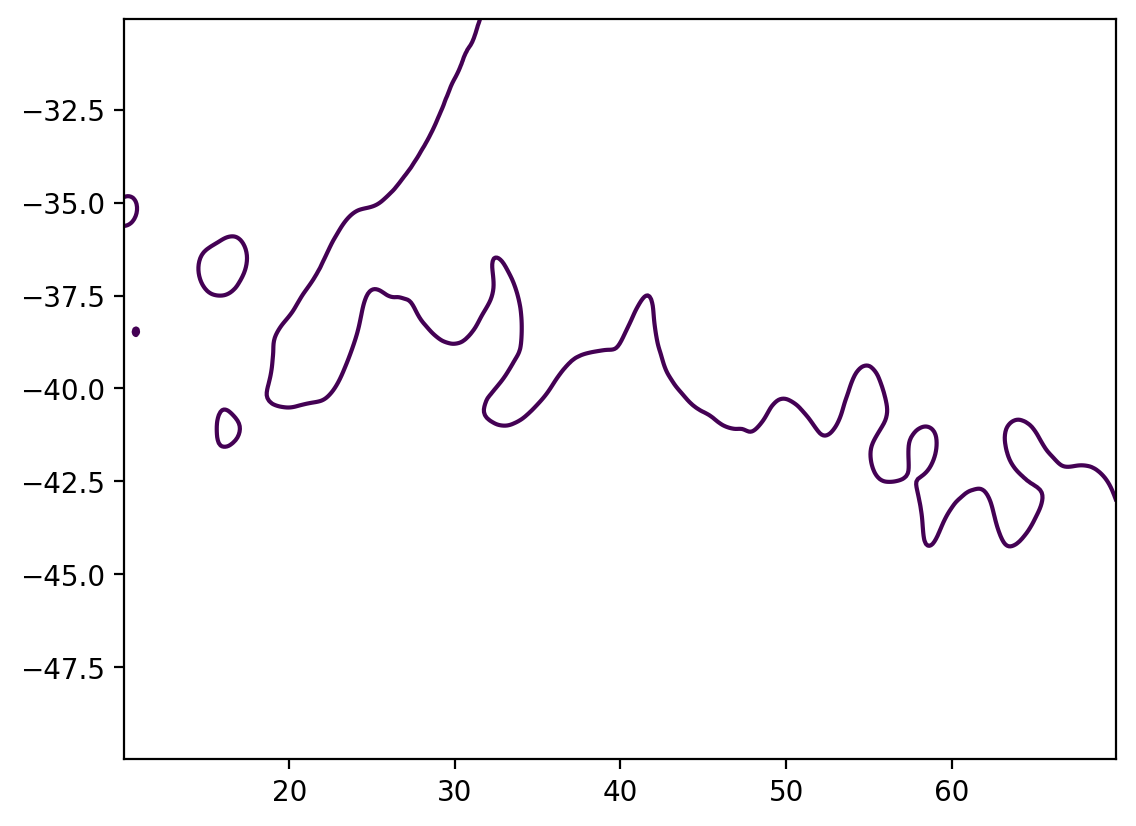

In [10]:
sc = plt.contour(zds['xt_ocean'],zds['yt_ocean'],zds["sea_level"].isel(time=0), levels=[0.2])
zz = sc.collections[0].get_paths()
for m in np.arange(np.size(zz)):
 if np.sum((zz[m].vertices[:,1]<(-38)) | (zz[m].vertices[:,1]>(-34)) | (zz[m].vertices[:,0]>(18)))==0 :
  xc0 = zz[m].vertices[:,0]
  yc0 = zz[m].vertices[:,1]

dp0 = np.ravel((np.full(len(xc0), tds['st_ocean'][30]),
                np.full(len(xc0), tds['st_ocean'][15])))
xc0 = np.ravel((xc0,xc0))
yc0 = np.ravel((yc0,yc0))

sh: None: command not found
INFO: Compiled JITParticleAdvectionRK4_3D ==> /jobfs/141649443.gadi-pbs/parcels-710/d8e73a1f01d395460d254554e5cd2323_0.so
INFO: Temporary output files are stored in /scratch/if69/cxa561/out-OJNUGROP.
INFO: You can use "parcels_convert_npydir_to_netcdf /scratch/if69/cxa561/out-OJNUGROP" to convert these to a NetCDF file during the run.
100% (5184000.0 of 5184000.0) |##########| Elapsed Time: 0:40:30 Time:  0:40:30


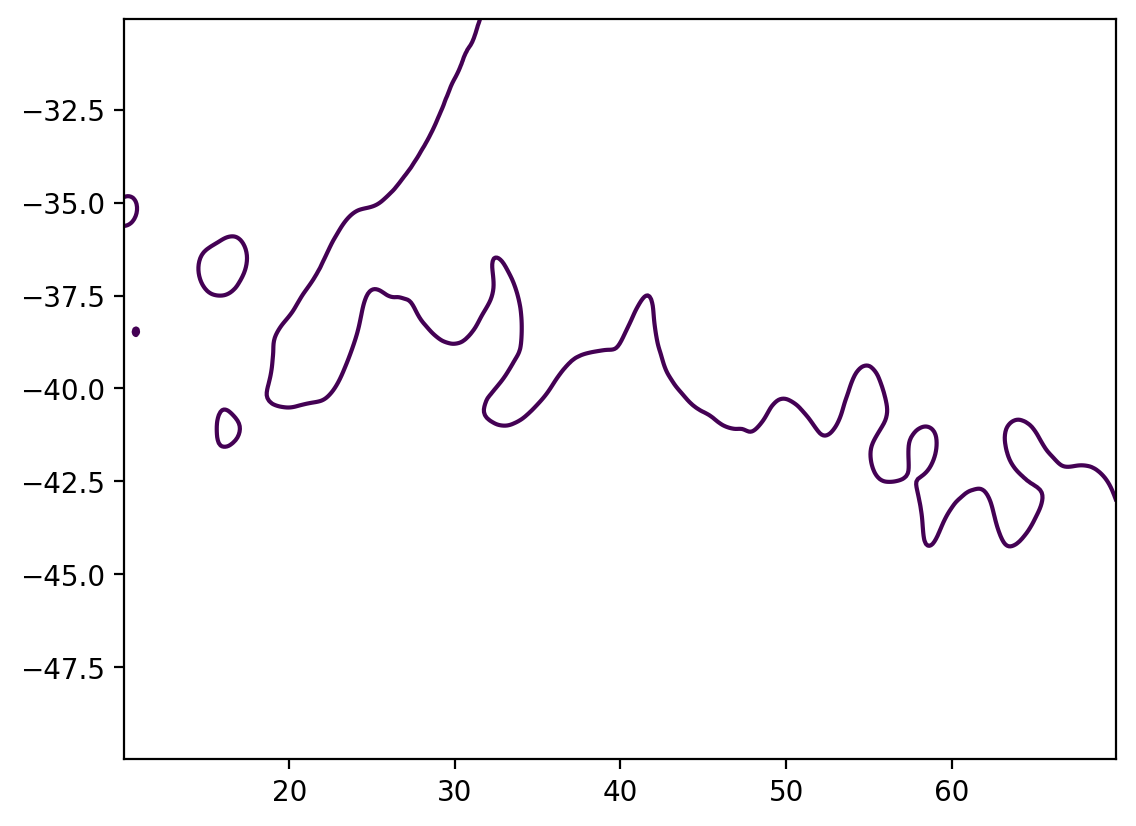

In [9]:
dp0 = np.ravel((np.full(len(xc0), tds['st_ocean'][30]),
                np.full(len(xc0), tds['st_ocean'][15])))
xc0 = np.ravel((xc0,xc0))
yc0 = np.ravel((yc0,yc0))

pset = ParticleSet.from_list(fieldset=fieldset,   # the fields on which the particles are advected
                             pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
                             lon=xc0,            # a vector of release longitudes
                             lat=yc0,            # a vector of release latitudes
                             depth=dp0,        # a vector of release depths
                             time=0.)             # set time to start start time of daily velocity fields

output_file = pset.ParticleFile(
    name='/scratch/if69/cxa561/temp',
    outputdt=timedelta(days=1)
)

pset.execute(
    AdvectionRK4_3D,
    runtime=timedelta(days=60),
    dt=timedelta(hours=1),
    output_file=output_file,
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle} 
)

output_file.close()

<xarray.DataArray 'z' ()>
array(213.91403, dtype=float32)
Attributes:
    long_name:      
    standard_name:  depth
    units:          m
    positive:       down

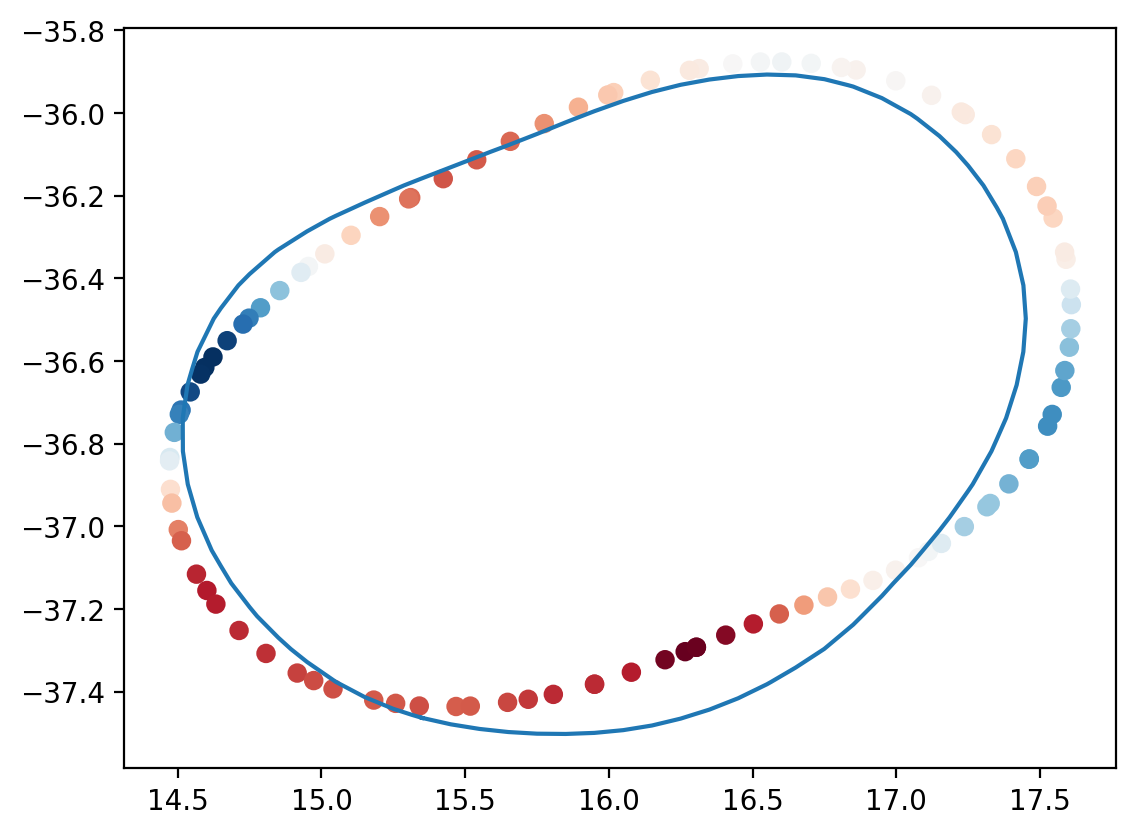

In [19]:
plt.plot(xp0[:,0],yp0[:,0])
plt.scatter(xp0[:,1],yp0[:,1],c=zp0[:,1],cmap="RdBu_r")
zp0[1,1].compute()

In [9]:
parcels = xr.open_mfdataset('/scratch/if69/cxa561/temp.nc')
Np = int(len(xc0)/2)
xp0 = parcels['lon'][0:Np,:]
yp0 = parcels['lat'][0:Np,:]
zp0 = parcels['z'][0:Np,:]
xp1 = parcels['lon'][Np:(2*Np),:]
yp1 = parcels['lat'][Np:(2*Np),:]
zp1 = parcels['z'][Np:(2*Np),:]
np.shape(xp0)

NameError: name 'xc0' is not defined